<a href="https://colab.research.google.com/github/Muhammad-Ahtasham/Fashion-Gan/blob/master/FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing Dependencies**

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00


In [ ]:
# !pip install tensorflow-gpu

## Importing libraries

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.05UL7L_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.05UL7L_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next()['label']

2

# Visualization

In [6]:
import numpy as np
dataiterator = ds.as_numpy_iterator()

In [7]:
# dataiterator.next()

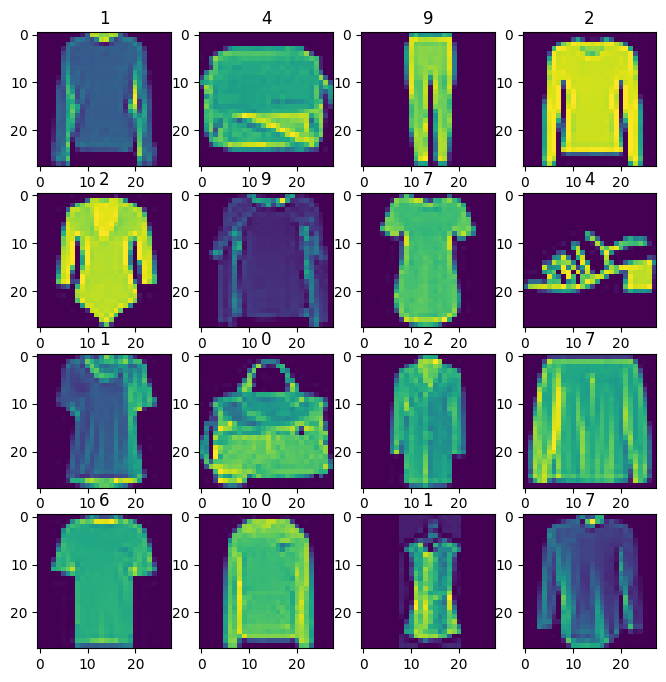

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(8,8))
index = 0
for x in range(4):
  for y in range(4):
    ax[x,y].imshow(dataiterator.next()['image'])
    ax[x,y].title.set_text(dataiterator.next()['label'])

In [9]:
def scale_image(data):
  image = data['image']
  return image/255

In [10]:
ds = ds.map(scale_image)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [13]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, 4, activation='sigmoid', padding='same'))

  return model

In [14]:
generator = build_generator()

In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [16]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 2s 2s/step


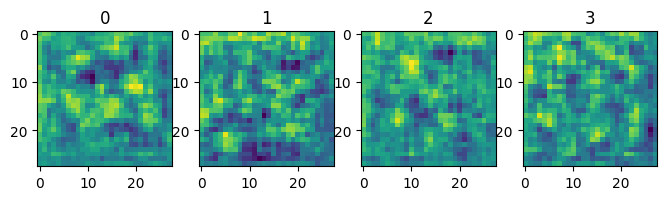

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(8,8))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

In [18]:
def build_discriminator():
  model = Sequential()
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [19]:
discriminator = build_discriminator()

In [20]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [21]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 306ms/step


array([[0.4980147]], dtype=float32)

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [24]:
from tensorflow.keras.models import Model

In [35]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake = tf.concat([noise_real, noise_fake], axis=0)

      #calculate the loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables, self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables)))

    with tf.GradientTape() as g_tape:
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
      predicted_labels = self.discriminator(gen_images, training=False)
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables, self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables)))

    return {'d_loss': total_d_loss, 'g_loss': total_g_loss}



In [36]:
fashgan = FashionGAN(generator, discriminator)

In [37]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [38]:
import os
# from tensorflow.keras.preprocessing import array_to_img
from tensorflow.keras.callbacks import Callback

In [39]:
class GANMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [40]:
hist = fashgan.fit(ds, epochs=20, callbacks=[GANMonitor()])

Epoch 1/20


UnboundLocalError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "<ipython-input-35-53fa014ae582>", line 32, in train_step
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables, self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables)))

    UnboundLocalError: local variable 'dgrad' referenced before assignment
